<a href="https://colab.research.google.com/github/severine-baudry/P2_dog_classification/blob/VALID_9P/Transfer_Learning_Solution_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog breed


## Download images

In [ ]:
import os
dogpath="dog_images/" 
pwd = !pwd

check_data = False
if not os.path.exists(dogpath):
  !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
  !unzip -q dogImages.zip
  !mv dogImages dog_images


--2020-11-16 14:35:57--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.112
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  75.0MB/s    in 14s     

2020-11-16 14:36:11 (77.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



## Load and transform data

In [ ]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
train_dir = os.path.join(dogpath, 'train/')
valid_dir = os.path.join(dogpath, 'valid/')
test_dir = os.path.join(dogpath, 'test/')


### transform data

In [ ]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num valid images:  835
Num test images:  836


### Data loaders and data visualization

In [ ]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [ ]:
print(train_data.class_to_idx.items())
dog_labels = { v:k for k,v in train_data.class_to_idx.items()}

dict_items([('001.Affenpinscher', 0), ('002.Afghan_hound', 1), ('003.Airedale_terrier', 2), ('004.Akita', 3), ('005.Alaskan_malamute', 4), ('006.American_eskimo_dog', 5), ('007.American_foxhound', 6), ('008.American_staffordshire_terrier', 7), ('009.American_water_spaniel', 8), ('010.Anatolian_shepherd_dog', 9), ('011.Australian_cattle_dog', 10), ('012.Australian_shepherd', 11), ('013.Australian_terrier', 12), ('014.Basenji', 13), ('015.Basset_hound', 14), ('016.Beagle', 15), ('017.Bearded_collie', 16), ('018.Beauceron', 17), ('019.Bedlington_terrier', 18), ('020.Belgian_malinois', 19), ('021.Belgian_sheepdog', 20), ('022.Belgian_tervuren', 21), ('023.Bernese_mountain_dog', 22), ('024.Bichon_frise', 23), ('025.Black_and_tan_coonhound', 24), ('026.Black_russian_terrier', 25), ('027.Bloodhound', 26), ('028.Bluetick_coonhound', 27), ('029.Border_collie', 28), ('030.Border_terrier', 29), ('031.Borzoi', 30), ('032.Boston_terrier', 31), ('033.Bouvier_des_flandres', 32), ('034.Boxer', 33), ('

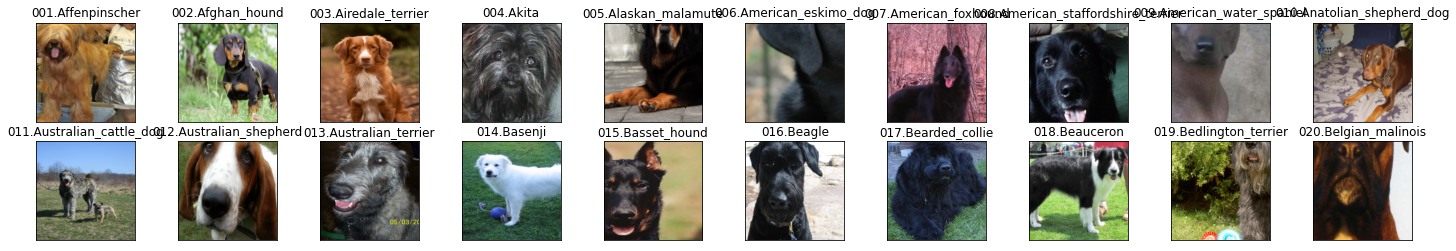

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title( dog_labels[idx])

# Define the model

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
n_inputs = vgg16.classifier[6].in_features

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn


# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(dog_labels))
)

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
#print(vgg16.classifier[6].out_features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 30
display_interval = 20
l_train_loss = np.empty(n_epochs)
l_valid_loss = np.empty(n_epochs)
l_train_accuracy = np.empty(n_epochs)
l_valid_accuracy = np.empty(n_epochs)
print("Begin Training")

for epoch in range( n_epochs):
    # keep track of training and validation loss
    train_loss = 0.0
    correct = 0
    nsample = 0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.detach().item()*data.shape[0]
        estimated = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(estimated.eq(target.data.view_as(estimated))).cpu().numpy())
        nsample += data.shape[0]
    print('Epoch %d, loss: %.4f accuracy %.3f' %
          (epoch+1, train_loss / nsample, correct/float(nsample)))
    l_train_loss[epoch] = train_loss / nsample
    l_train_accuracy[epoch] = correct/float(nsample)
    train_loss = 0.0
    correct = 0
    nsample = 0
    with torch.no_grad():
        vgg16.eval()
        valid_loss = 0.
        valid_nsample = 0
        valid_correct = 0
        for batch_i, (data, target) in enumerate(valid_loader):
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            output = vgg16(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.shape[0]
            estimated = output.data.max(1, keepdim=True)[1]
            valid_correct += np.sum(np.squeeze(estimated.eq(target.data.view_as(estimated))).cpu().numpy())
            valid_nsample += data.shape[0]
        
        print("VALID : Epoch %d,loss: %.4f accuracy %.3f" % 
              (epoch+1, valid_loss / valid_nsample, valid_correct / float(valid_nsample) ) )  
        l_valid_loss[epoch] = valid_loss / valid_nsample
        l_valid_accuracy[epoch] = valid_correct / float(valid_nsample)
 


Begin Training
Epoch 1, loss: 4.8683 accuracy 0.012
VALID : Epoch 1,loss: 4.8018 accuracy 0.038
Epoch 2, loss: 4.7287 accuracy 0.083
VALID : Epoch 2,loss: 4.6464 accuracy 0.111
Epoch 3, loss: 4.5159 accuracy 0.158
VALID : Epoch 3,loss: 4.3848 accuracy 0.151
Epoch 4, loss: 4.1325 accuracy 0.216
VALID : Epoch 4,loss: 3.8747 accuracy 0.253
Epoch 5, loss: 3.5694 accuracy 0.304
VALID : Epoch 5,loss: 3.2822 accuracy 0.317
Epoch 6, loss: 2.9671 accuracy 0.400
VALID : Epoch 6,loss: 2.7941 accuracy 0.404
Epoch 7, loss: 2.5281 accuracy 0.455
VALID : Epoch 7,loss: 2.4316 accuracy 0.450
Epoch 8, loss: 2.2273 accuracy 0.487
VALID : Epoch 8,loss: 2.2039 accuracy 0.479
Epoch 9, loss: 2.0182 accuracy 0.519
VALID : Epoch 9,loss: 2.0821 accuracy 0.485
Epoch 10, loss: 1.8709 accuracy 0.533
VALID : Epoch 10,loss: 1.8964 accuracy 0.515
Epoch 11, loss: 1.7727 accuracy 0.555
VALID : Epoch 11,loss: 1.7965 accuracy 0.515
Epoch 12, loss: 1.6755 accuracy 0.570
VALID : Epoch 12,loss: 1.6916 accuracy 0.534
Epoch 1

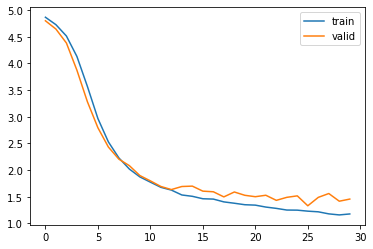

In [ ]:
plt.plot(l_train_loss, label = 'train')
plt.plot(l_valid_loss, label = 'valid')
plt.legend()

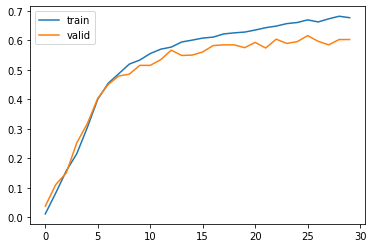

In [ ]:
plt.plot(l_train_accuracy, label = 'train')
plt.plot(l_valid_accuracy, label = 'valid')
plt.legend()

In [ ]:
with torch.no_grad():
    vgg16.eval()
    test_loss = 0.
    test_nsample = 0
    test_correct = 0
    for batch_i, (data, target) in enumerate(test_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = vgg16(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.shape[0]
        estimated = output.data.max(1, keepdim=True)[1]
        test_correct += np.sum(np.squeeze(estimated.eq(target.data.view_as(estimated))).cpu().numpy())
        test_nsample += data.shape[0]
print("TEST : Epoch %d,loss: %.4f accuracy %.3f" % 
      (epoch+1, test_loss / test_nsample, test_correct / float(test_nsample) ) )  



TEST : Epoch 30,loss: 1.4636 accuracy 0.603
